In [3]:
from rpy2 import robjects
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates



import pandas as pd
import numpy as np
import datetime
import yaml
import os

# Convert pandas dataframe
from rpy2.robjects import pandas2ri
pandas2ri.activate()

output_dir = 'output_12-20-2gamma/'
#output_dir = 'output_12-10-gammaI/'

dept_avail = os.listdir(output_dir)


rainfall = pd.read_csv('haiti-data/fromAzman/rainfall.csv', index_col = 0, parse_dates = True)
cases    = pd.read_csv('haiti-data/fromAzman/cases_corrected.csv', index_col=0, parse_dates =True)


compartments = ['S', 'I', 'A', 'RA1', 'RA2', 'RA3', 'RI1', 'RI2', 'RI3', 'W', 'B', 'cases', 
                 "VSd", "VRI1d", "VRI2d", "VRI3d", "VRA1d", "VRA2d", "VRA3d",
                 "VSdd", "VRI1dd", "VRI2dd", "VRI3dd", "VRA1dd", "VRA2dd", "VRA3dd",
                 "VSd_alt", "VRI1d_alt", "VRI2d_alt", "VRI3d_alt", "VRA1d_alt", "VRA2d_alt", "VRA3d_alt",
                 "VSdd_alt", "VRI1dd_alt", "VRI2dd_alt", "VRI3dd_alt", "VRA1dd_alt", "VRA2dd_alt", "VRA3dd_alt"]

stream = open('haiti-data/input_parameters.yaml', 'r')
input_parameters = yaml.load(stream)

dept_name = [list(pop.keys())[0] for pop in input_parameters['population']]

t_start = input_parameters['t_start']
t_for = datetime.date(2029,12,21)

# computes precipitation sample
def project_rain(rainfall, tf):
    nd = 14 #days sampled - must be multiple of 7 d
    
    dti = rainfall.iloc[0].name.date()
    dtf = rainfall.iloc[-1].name.date()
    
    rain_prj_index = pd.DatetimeIndex(start =  dtf + datetime.timedelta(1), 
                                      end = tf, freq = 'D')
    rain_prj = np.zeros((rain_prj_index.shape[0], 10))

    # Full years of data available
    years = range(dti.year+1, dtf.year-1)

    # each nd days, assign an al precipitation.
    for i, date in enumerate(pd.date_range(dtf + datetime.timedelta(1), tf, freq = str(nd)+'D')):
        dd = date.day
        if (date.month == 2 and dd == 29):
            dd = 28
        pick = datetime.date(np.random.choice(years), date.month, dd)
        #print(pick, i, rainfall.loc[pd.date_range(pick, pick + datetime.timedelta(nd-1))].values.shape, rain_prj[nd * i: nd * (i+1)].shape)
        rain_prj[nd * i: nd * (i+1)] = rainfall.loc[pd.date_range(pick, pick + datetime.timedelta(nd-1))].values

    rain_prj = pd.DataFrame(rain_prj, index = rain_prj_index, columns = dept_name)
    
    return rain_prj

rain_prj = project_rain(rainfall, t_for)
rain = pd.concat((rainfall, rain_prj))
rain.to_csv('haiti-data/proj/rainfall.csv', index_label = 'date')

### Extracting best performing parameters

In [4]:
index = pd.DatetimeIndex(start =  t_start,  end = t_for, freq = 'W-SAT')
r_source = robjects.r['source'];

all_data = {}
#all_params = {}
for i, dp in enumerate(dept_avail):
    dept_data = {}
    robjects.r('departement <- "' + dp + '"')
    robjects.r('output_dir <- "' + output_dir + '"')
    robjects.r('run_level <- 4')
    robjects.r('nsim <- 10')
    robjects.r('t_vacc_start <- "' + str('2010-01-01') + '"')
    robjects.r('t_vacc_end  <- "' + str('2010-01-01') + '"')
    robjects.r('p1d_reg <- 0') 
    robjects.r('r_v_year <- 0')
    print(dp)
    r_source('~/phd/haiti-ocv-pomp/scripts/forecast_haitiOCV.R')
    if i == 0:
        all_params = pd.DataFrame(np.zeros((len(dept_avail), len(robjects.r('names(params)')))),  columns = robjects.r('names(params)'), index = dept_avail) 
    all_params.loc[dp] = robjects.r['params']
    for comp in compartments:
        temp = pandas2ri.ri2py(robjects.r[comp])
        temp.index = index
        temp.drop('date',axis=1, inplace = True)
        dept_data[comp] = temp
    all_data[dp] = dept_data
    #all_params[dp] = params

    

# Convert years in days, 'mu', 'alpha'
rates = [ "gammaI", "gammaA", "rhoA", 'rhoI']
params_disp = all_params.copy()
params_disp.loc[:,'rhoI'] = params_disp.loc[:,'XrhoI'] * params_disp.loc[:,'rhoA']
params_disp.loc[:,'thetaA'] = params_disp.loc[:,'XthetaA'] * params_disp.loc[:,'thetaI']
params_disp.drop(['mu', 'alpha', 'XrhoI', 'XthetaA', 't_vacc_start', 't_vacc_end', 'p1d_reg', 'r_v_year'], axis =1, inplace = True)
print(params_disp)
for p in rates:
    params_disp.loc[:,p] =  1/(params_disp.loc[:,p]/365.25)
    
params_disp = params_disp.reindex(columns=sorted(params_disp.columns))

Nord-Est
Nord


/usr/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Parsed with column specification:
cols(
  date = col_date(format = ""),
  Artibonite = col_double(),
  Centre = col_double(),
  Grande_Anse = col_double(),
  Nippes = col_double(),
  Nord = col_double(),
  `Nord-Est` = col_double(),
  `Nord-Ouest` = col_double(),
  Ouest = col_double(),
  Sud = col_double(),
  `Sud-Est` = col_double()
)

  warnings.warn(x, RRuntimeWarning)
/usr/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/usr/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Joining, by = c("loglik", "loglik.se", "sigma", "betaB", "mu_B", "XthetaA", "thetaI", "lambdaR", "gammaA", "gammaI", "r", "rhoA", "XrhoI", "std_W", "epsilon", "foi_add", "k"

Artibonite
Nord-Ouest
Ouest


/usr/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Parsed with column specification:
cols(
  .default = col_double(),
  t_vacc_start = col_integer(),
  t_vacc_end = col_integer(),
  r_v_year = col_integer(),
  p1d_reg = col_integer(),
  lambda = col_integer(),
  H = col_integer(),
  D = col_integer()
)

  warnings.warn(x, RRuntimeWarning)
/usr/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Joining, by = c("loglik", "loglik.se", "sigma", "betaB", "mu_B", "XthetaA", "thetaI", "lambdaR", "gammaA", "gammaI", "r", "rhoA", "XrhoI", "std_W", "epsilon", "foi_add", "k", "Rtot_0", "t_vacc_start", "t_vacc_end", "r_v_year", "p1d_reg", "lambda", "H", "D", "mu", "alpha")

  warnings.warn(x, RRuntimeWarning)


Grande_Anse
Sud
Centre
Sud-Est
Nippes
                sigma     betaB         mu_B    thetaI     lambdaR          r  \
Nord-Est     0.024788  2.574267  8334.100223  0.030532    1.953626   4.344529   
Nord         0.094367  4.321421    84.132031  0.000517    1.751547  11.011206   
Artibonite   0.243304  0.316733    97.951331  0.000581    0.742508   0.652516   
Nord-Ouest   0.102885  2.200403  2128.994934  0.016657   12.679690   3.833115   
Ouest        0.055829  1.651073    60.893234  0.000352    5.483935   1.572933   
Grande_Anse  0.999828  0.703322    97.115168  0.001814  136.175094   4.388651   
Sud          0.032203  4.764146    66.505036  0.002863  175.794006   4.829309   
Centre       0.947805  0.212603    75.525099  0.001671    1.054782   1.372604   
Sud-Est      0.147182  3.986087   113.229101  0.000869    1.624435   0.584042   
Nippes       0.160792  4.839928   427.992656  0.005544    0.579726   1.991182   

                  gammaI       gammaA       rhoA   foi_add   epsilon  

In [96]:
(1/(2.533697*0.006199))*365

23238.95264156017

In [47]:
all_params

,sigma,betaB,mu_B,thetaI,XthetaA,lambdaR,r,gammaI,gammaA,rhoA,XrhoI,foi_add,epsilon,k,std_W,Rtot_0,H,D,mu,alpha
Nord-Est,0.024788,2.574267,8334.100223,0.030532,0.472285,1.953626,4.344529,40.704818,104.324868,0.372302,0.678034,0.000038,0.617016,47.637173,0.037352,0.017735,393967.0,243.0,0.015866,1.461
Nord,0.094367,4.321421,84.132031,0.000517,0.133569,1.751547,11.011206,2480.365329,63.602104,21.047936,0.982735,0.000522,0.590516,281.996993,0.016061,0.009241,1067177.0,505.0,0.015866,1.461
Artibonite,0.243304,0.316733,97.951331,0.000581,0.344146,0.742508,0.652516,304.090031,205.477224,0.952652,0.705182,0.000337,0.803858,435.472914,0.013238,0.005673,1727524.0,353.0,0.015866,1.461
Nord-Ouest,0.102885,2.200403,2128.994934,0.016657,0.592084,12.679690,3.833115,2413.473691,49.809753,2.649136,0.007124,0.000245,0.199968,98.806077,0.036738,0.113975,728807.0,347.0,0.015866,1.461
Ouest,0.055829,1.651073,60.893234,0.000352,0.749771,5.483935,1.572933,4655.921448,1614.981505,40.697131,0.087335,0.000227,0.793743,38.570723,0.028582,0.132384,4029705.0,809.0,0.015866,1.461
Grande_Anse,0.999828,0.703322,97.115168,0.001814,0.045803,136.175094,4.388651,2156.342285,44.634275,0.858907,0.071850,0.000032,0.169841,74.436046,0.037528,0.047330,468301.0,245.0,0.015866,1.461
Sud,0.032203,4.764146,66.505036,0.002863,0.010302,175.794006,4.829309,3104.616640,269.179575,2.899880,0.392359,0.000996,0.929264,94.649902,0.040326,0.074225,774976.0,292.0,0.015866,1.461
Centre,0.947805,0.212603,75.525099,0.001671,0.000790,1.054782,1.372604,945.430397,538.705177,0.383455,0.011783,0.000290,0.951411,177.839479,0.019525,0.013496,746236.0,214.0,0.015866,1.461
Sud-Est,0.147182,3.986087,113.229101,0.000869,0.098435,1.624435,0.584042,1179.208744,724.119678,0.045709,0.804924,0.000403,0.226665,3.315881,0.006203,0.009600,632601.0,311.0,0.015866,1.461
Nippes,0.160792,4.839928,427.992656,0.005544,0.248099,0.579726,1.991182,815.292318,30.245708,2.533697,0.006199,0.000114,0.041865,39.150247,0.033881,0.715564,342525.0,270.0,0.015866,1.461


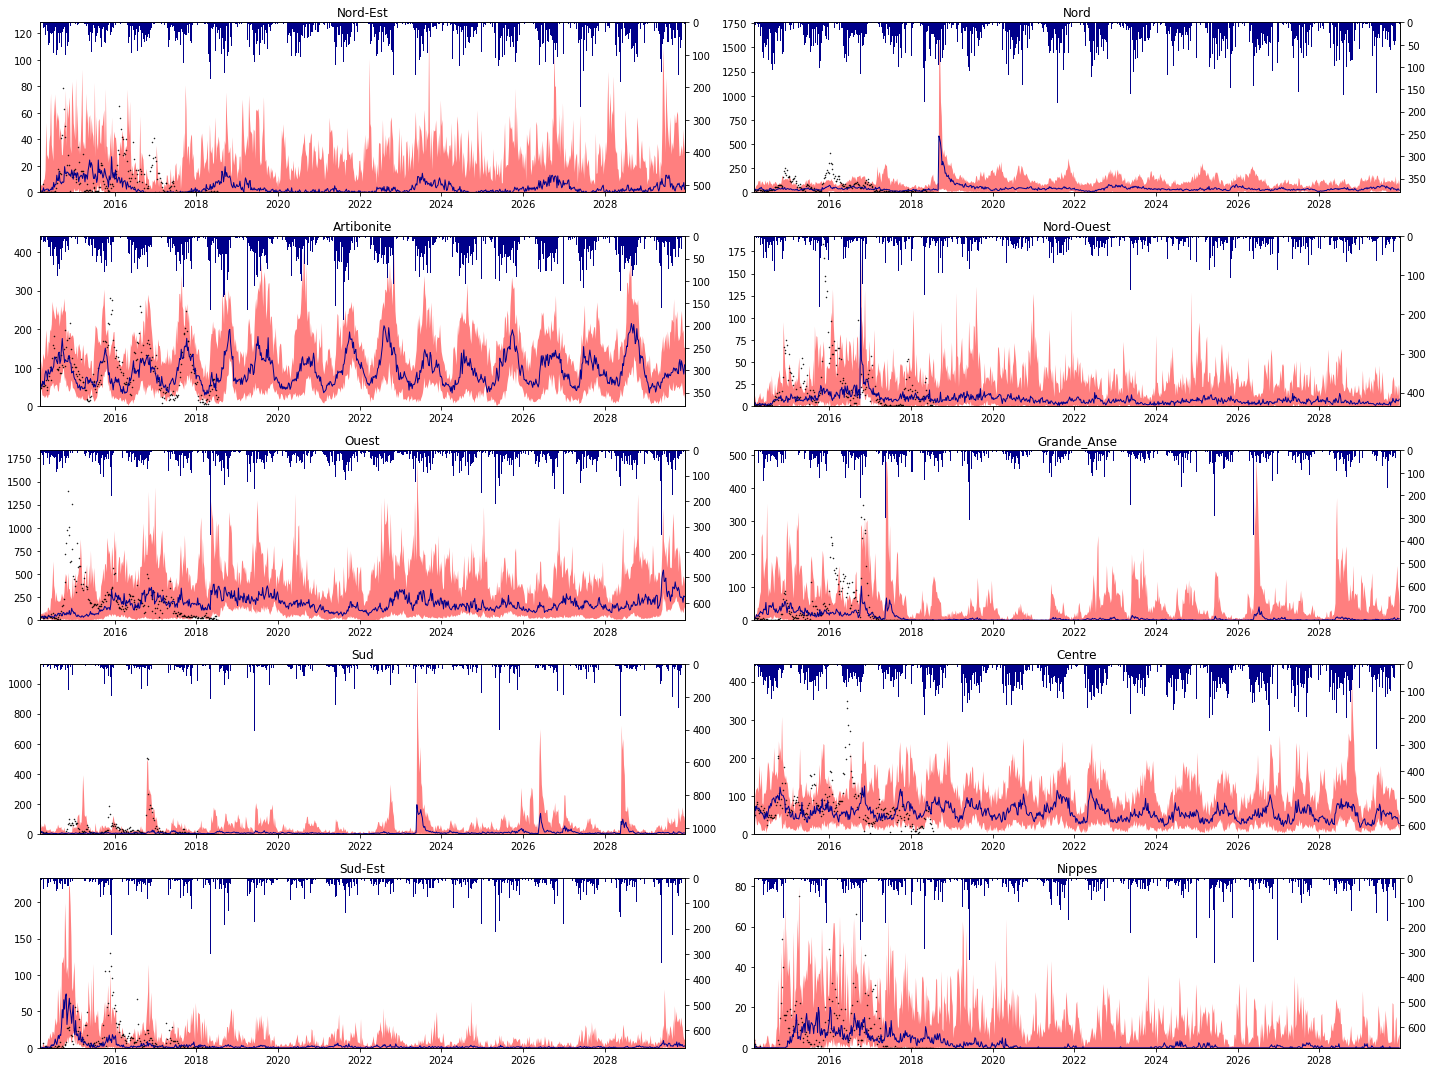

In [8]:
fig, axes = plt.subplots((len(all_data))//2, 2, figsize=(20,15), squeeze = True);
axes = axes.flatten();
for i, dp in enumerate(dept_avail):
    axt =  axes[i].twinx()
    axes[i].plot(cases[dp][t_start:], marker='.', linestyle='-',color='k', linewidth=0, markersize=1 ) 
    axes[i].fill_between(all_data[dp]['cases']['q05'].index, all_data[dp]['cases']['q05'], all_data[dp]['cases']['q95'], alpha = .5, color = 'red', linewidth = 0)
    #axes[i].plot(all_data[dp]['cases']['mean'], linewidth=1, alpha = 1,linestyle='-.', color = 'black')
    axes[i].plot(all_data[dp]['cases']['q50'], alpha = 1,linestyle='-', linewidth = 1, color = 'darkblue')
    axt.bar(pd.date_range(t_start,t_for, freq='W-SAT').date, rain[dp].resample('W-SAT').sum()[t_start:t_for], 
                label = r'Rainfall', color = 'darkblue', width=7, alpha = 1)

    axes[i].set_title(dp)
    axes[i].set_ylim(0)
    axt.set_ylim(2*max(rain[dp].resample('W-SAT').sum()[t_start:t_for]),0) # check if only reverse y
    axes[i].set_xlim(t_start, t_for)
    #axes[i].legend()
    
fig.tight_layout()

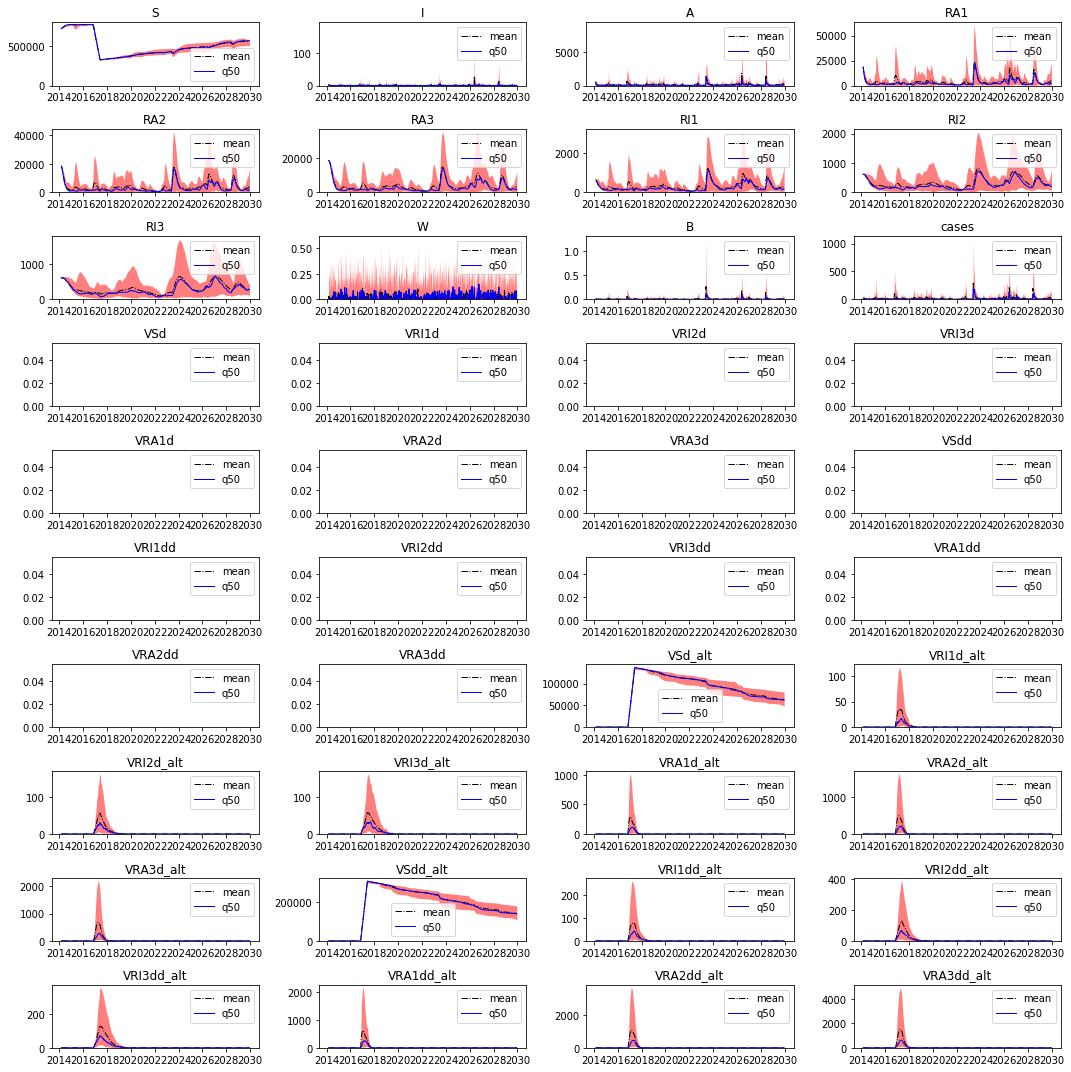

In [9]:
dp = 'Sud'
fig, axes = plt.subplots((len(compartments))//4, 4, figsize=(15,15), squeeze = True);
axes = axes.flatten();
for i, comp in enumerate(compartments):
    axes[i].fill_between(all_data[dp][comp]['q05'].index, all_data[dp][comp]['q05'], all_data[dp][comp]['q95'], alpha = .5, color = 'red', linewidth = 0)
    axes[i].plot(all_data[dp][comp]['mean'], linewidth=1, alpha = 1,linestyle='-.', color = 'black')
    axes[i].plot(all_data[dp][comp]['q50'], alpha = 1,linestyle='-', linewidth = 1, color = 'blue') 
    axes[i].set_title(comp)
    axes[i].legend()
    axes[i].set_ylim(0)
    
fig.tight_layout()

In [19]:
class VaccinationScenario():
    
    def __init__(self, course_year, percent_completely_unvaccinated, percent_onedose, percent_twodoses, not_dep = []):
        pop = {'Artibonite':1727524,
            'Centre':746236,
            'Grande_Anse':468301,
            'Nippes':342525,
            'Nord':1067177,
            'Nord-Est':393967,
            'Nord-Ouest':728807,
            'Ouest':4029705,
            'Sud':774976,
            'Sud-Est':632601}
        
        ocv_order = ['Centre', 'Artibonite','Ouest','Nord-Ouest','Nord','Sud', 'Nippes','Nord-Est', 'Sud-Est','Grande_Anse']
        
        
        self.t_vacc_start = {}
        self.t_vacc_end = {}
        self.p1d_reg = {}
        self.r_v_year = {}
        
        #20% completely unvaccinated, 10% one-dose only, 70% two doses
        
        t_init = datetime.date(2018,7,14)
        days_per_departement = int((course_year*365)/len(ocv_order))
        
        for i, dp in enumerate(ocv_order):
            if dp not in not_dep:
                self.t_vacc_start[dp] = t_init + datetime.timedelta(days=i*days_per_departement)
                self.t_vacc_end[dp]   = t_init + datetime.timedelta(days=(i+1)*days_per_departement)
                self.p1d_reg[dp] = percent_onedose/(percent_onedose + percent_twodoses)
                self.r_v_year[dp] = pop[dp]*(100-percent_completely_unvaccinated)/100/days_per_departement * 365.25
                 
            else:
                self.t_vacc_start[dp] = t_init + datetime.timedelta(days=i*days_per_departement)
                self.t_vacc_end[dp]   = t_init + datetime.timedelta(days=(i+1)*days_per_departement)
                self.p1d_reg[dp] = 0
                self.r_v_year[dp] =0



S1 = VaccinationScenario(2, 20, 10, 70)
S2 = VaccinationScenario(2, 40, 20, 40, not_dep=['Ouest','Nord-Ouest','Sud', 'Nippes','Nord-Est', 'Sud-Est','Grande_Anse'])
S3 = VaccinationScenario(5, 3.33, 1.67, 95)
        
    

In [82]:
# Running simulation:
scenario = S1
index = pd.DatetimeIndex(start =  t_start,  end = t_for, freq = 'W-SAT')
r_source = robjects.r['source'];

all_data_vacc = {}
for i, dp in enumerate(dept_avail):
    dept_data = {}
    robjects.r('departement <- "' + dp + '"')
    robjects.r('output_dir <- "' + output_dir + '"')
    robjects.r('run_level <- 4')
    robjects.r('nsim <- 10')
    
    robjects.r('t_vacc_start <- "' + str(scenario.t_vacc_start[dp]) + '"')
    robjects.r('t_vacc_end  <- "' + str(scenario.t_vacc_end[dp]) + '"')
    robjects.r('p1d_reg <- ' + str(scenario.p1d_reg[dp]))
    robjects.r('r_v_year <- ' + str(scenario.r_v_year[dp]))

    r_source('~/phd/haiti-ocv-pomp/scripts/forecast_haitiOCV.R')
  
    for comp in compartments:
        temp = pandas2ri.ri2py(robjects.r[comp])
        temp.index = index
        temp.drop('date',axis=1, inplace = True)
        dept_data[comp] = temp
    all_data_vacc[dp] = dept_data
    #all_params[dp] = params


|
=====
                                                                   
|
   8%

|
                                                             
|
  16%

|
                                                       
|
  24%

|
                                                 
|
  32%

|
                                           
|
  40%

|
                                     
|
  48%

|
                              
|
  58%

|
                        
|
  67%

|
                
|
  75%    1 MB

|
          
|
  83%    1 MB

|
     
|
  91%    1 MB

|

|
 100%    1 MB




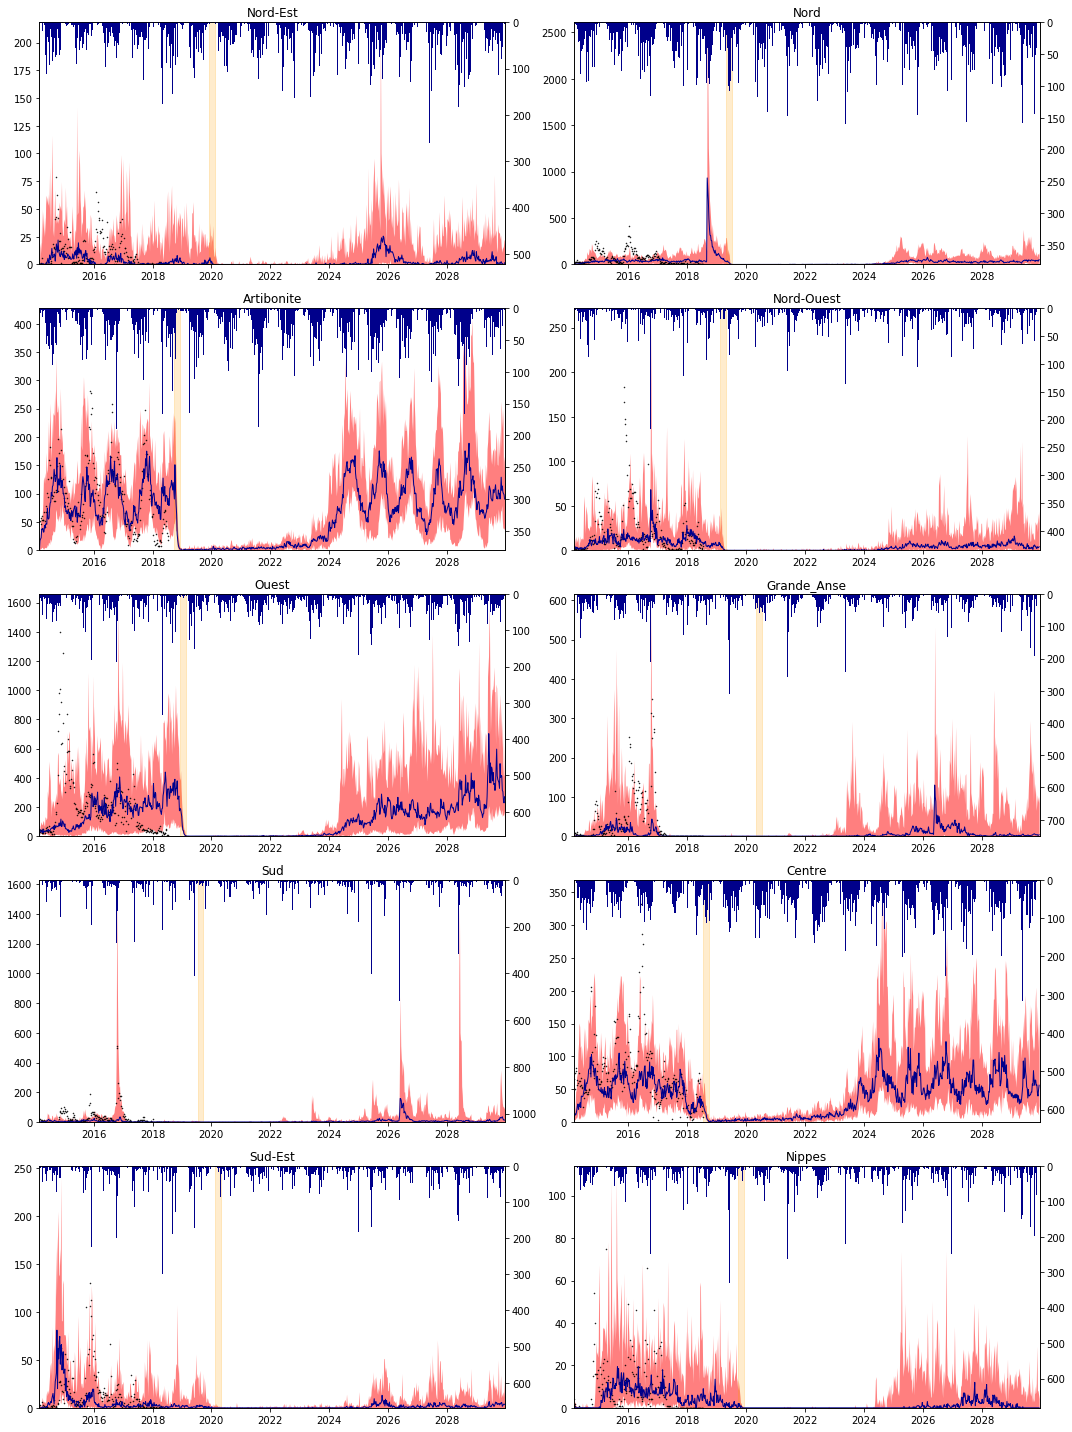

In [83]:
fig, axes = plt.subplots((len(all_data))//2, 2, figsize=(15,20), squeeze = True);
axes = axes.flatten();
for i, dp in enumerate(dept_avail):
    axt =  axes[i].twinx()
    axes[i].plot(cases[dp][t_start:], marker='.', linestyle='-',color='k', linewidth=0, markersize=1 ) 
    axes[i].fill_between(all_data_vacc[dp]['cases']['q05'].index, all_data_vacc[dp]['cases']['q05'], all_data_vacc[dp]['cases']['q95'], alpha = .5, color = 'red', linewidth = 0)
    axes[i].plot(all_data_vacc[dp]['cases']['q50'], alpha = 1,linestyle='-', linewidth = 1, color = 'darkblue')
    axt.bar(pd.date_range(t_start,t_for, freq='W-SAT').date, rain[dp].resample('W-SAT').sum()[t_start:t_for], 
                label = r'Rainfall', color = 'darkblue', width=7, alpha = 1)

    axes[i].set_title(dp)
    axes[i].set_ylim(0)
    axt.set_ylim(2*max(rain[dp].resample('W-SAT').sum()[t_start:t_for]),0) # check if only reverse y
    axes[i].set_xlim(t_start, t_for)
    #axes[i].legend()
    

    # convert to matplotlib date representation
    start = mdates.date2num(scenario.t_vacc_start[dp])
    end = mdates.date2num(scenario.t_vacc_end[dp])
    width = end - start
    rect = Rectangle((start, 0), width, 100+max(all_data_vacc[dp]['cases']['q95']), color='orange', alpha= 0.1)
    axes[i].add_patch(rect) 
    axes[i].add_artist(rect)
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width()/2.0
    cy = ry + rect.get_height()/1.5
    #axes[i].annotate(r'Vaccination', (cx, cy), color='black',# weight='bold', 
    #            fontsize=12, ha='center', va='center', rotation='vertical')

fig.tight_layout()

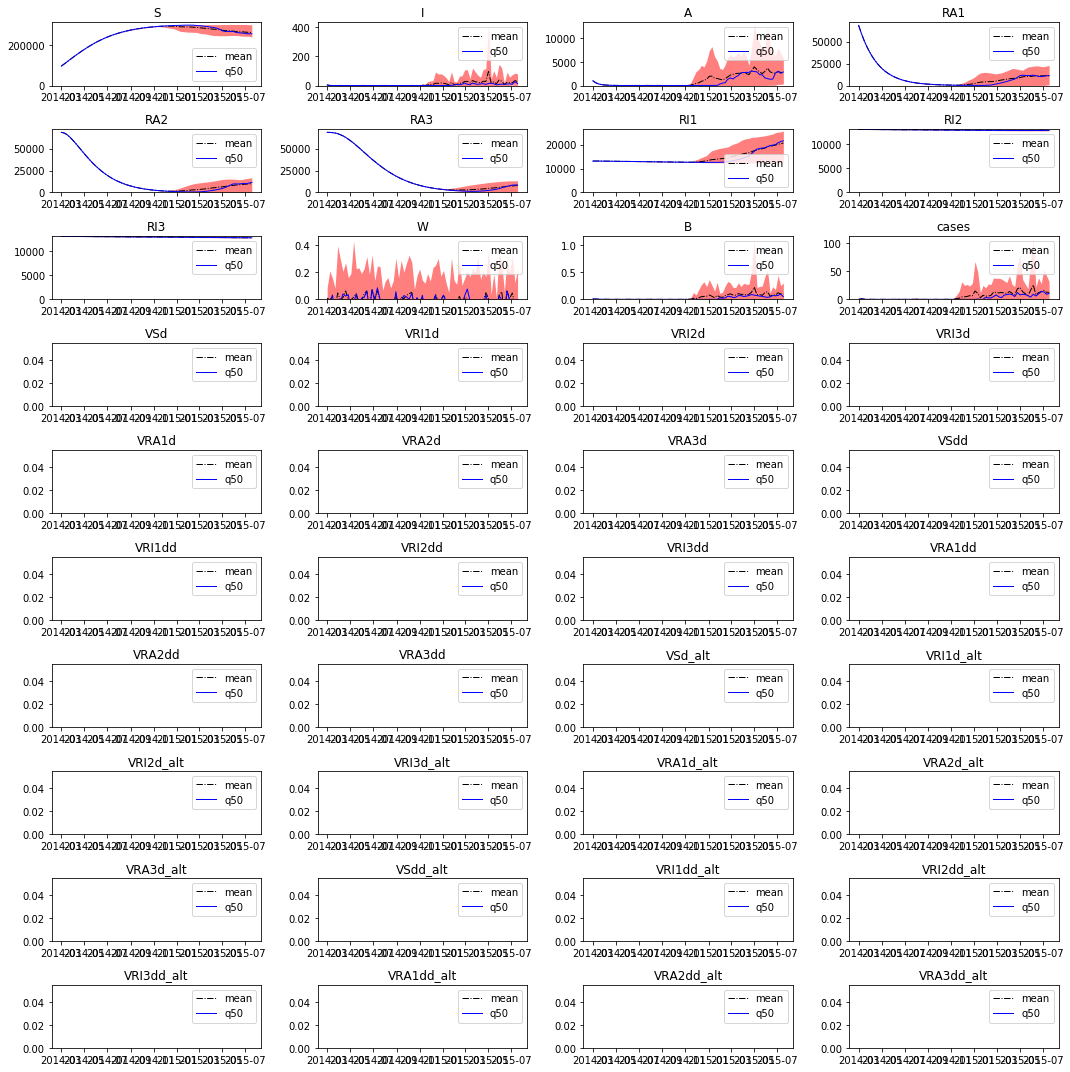

In [95]:
dp = 'Nippes'

ti = input_parameters['t_start']
tf = datetime.date(2015,7,21)

fig, axes = plt.subplots((len(compartments))//4, 4, figsize=(15,15), squeeze = True);
axes = axes.flatten();
for i, comp in enumerate(compartments):
    axes[i].fill_between(all_data_vacc[dp][comp]['q05'][ti:tf].index, all_data_vacc[dp][comp]['q05'][ti:tf], all_data_vacc[dp][comp]['q95'][ti:tf], alpha = .5, color = 'red', linewidth = 0)
    axes[i].plot(all_data_vacc[dp][comp]['mean'][ti:tf], linewidth=1, alpha = 1,linestyle='-.', color = 'black')
    axes[i].plot(all_data_vacc[dp][comp]['q50'][ti:tf], alpha = 1,linestyle='-', linewidth = 1, color = 'blue') 
    axes[i].set_title(comp)
    axes[i].legend()
    axes[i].set_ylim(0)
    
fig.tight_layout()

In [35]:

1/97*365

3.7628865979381443